# Computer Vision Project
## Lane lines detection
### 1. Camera Calibration

In [178]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import glob
import pickle

In [179]:
# load pre-calculated camera calibration result
with open("camera_calibration_result.p", mode='rb') as f:
    camera_calib = pickle.load(f)
mtx = camera_calib["mtx"]
dist = camera_calib["dist"]

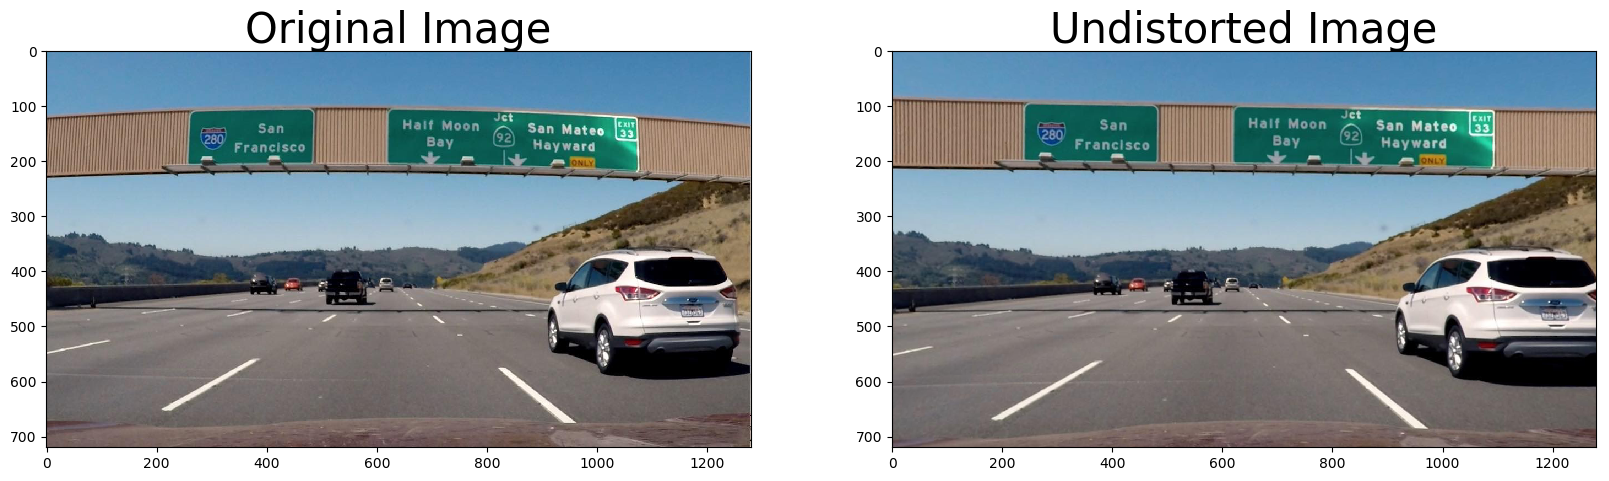

In [180]:
# Display undistorted images

raw = cv2.imread("test_images/quiz.png")
image = cv2.undistort(raw, mtx, dist, None, mtx)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
raw = cv2.cvtColor(raw,cv2.COLOR_BGR2RGB)
ax1.imshow(raw)
ax1.set_title('Original Image', fontsize=30)
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
ax2.imshow(image)
ax2.set_title('Undistorted Image', fontsize=30)

### 2. image processing

reference: https://github.com/pkern90/CarND-advancedLaneLines

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


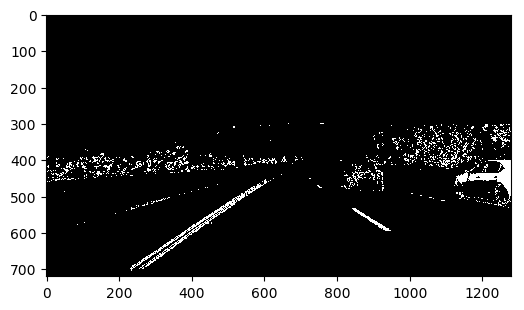

In [181]:
%load_ext autoreload
%autoreload 2
# This is the function imported from github~
from utilities import generate_lane_mask

raw = cv2.imread('test_images/frame1/1065.png')
undist = cv2.undistort(raw, mtx, dist, None, mtx)
mask = generate_lane_mask(undist, v_cutoff=300)
plt.imshow(mask,cmap='gray')

### 3 . Perspective Transform

In [182]:
def mouse_callback(event,x,y,flags,param):
    if event == cv2.EVENT_LBUTTONDOWN:
        print x, y

In [183]:
cv2.namedWindow('img',cv2.WINDOW_NORMAL)
cv2.setMouseCallback('img',mouse_callback)
cv2.imshow('img', undist)
cv2.waitKey(0)

255

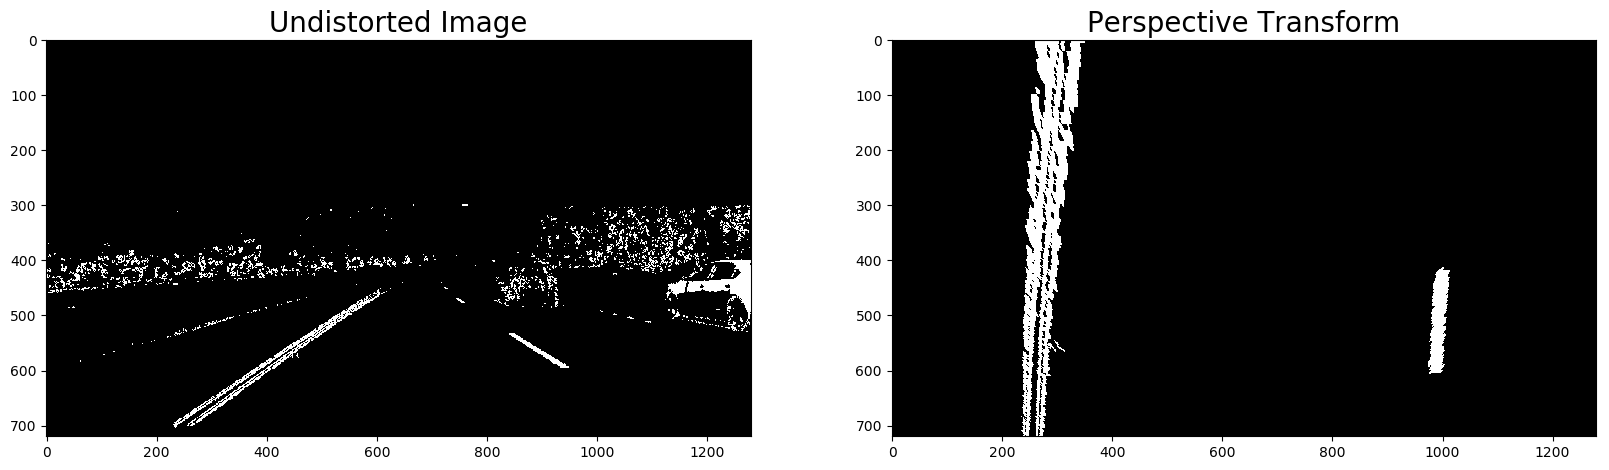

In [184]:

image = mask
src = np.float32(
        [[323, 682],
         [1105, 682],
         [564, 483],
         [756, 483]])

dst = np.float32(
        [[300,720],
         [1000,720],
         [300,0],
         [1000,0]])


imshape = raw.shape

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))

ax1.imshow(image, cmap="gray")
ax1.set_title('Undistorted Image',fontsize=20)

M = cv2.getPerspectiveTransform(src, dst)
#gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
warped = cv2.warpPerspective(image, M, (imshape[1], imshape[0]), flags=cv2.INTER_LINEAR)
ax2.imshow(warped, cmap="gray")
ax2.set_title('Perspective Transform',fontsize=20)

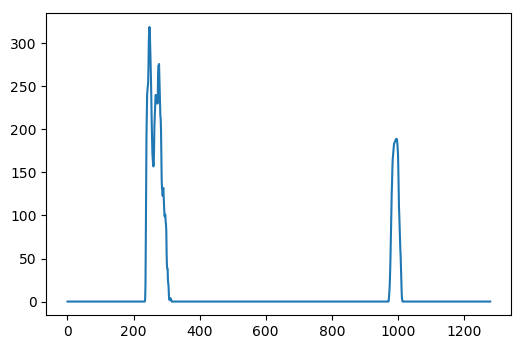

In [185]:
img = warped
histogram = np.sum(img[img.shape[0]/2:,:], axis=0)
plt.plot(histogram)

In [186]:
# Find left line and right line
mid_point = histogram.shape[0]/2
left_peak = np.argmax(histogram[0:mid_point])
right_peak = np.argmax(histogram[mid_point:]) + mid_point

print "right_peak:", right_peak
print "left_peak:", left_peak

right_peak: 995
left_peak: 248


In [187]:
window_num = 10
window_height = img.shape[0]/ window_num
window_width = 50

# store left and right points
left_points = []
right_points = []

for num in range(window_num):
    window_lower = img.shape[0] - num * window_height
    window_upper = max(window_lower - window_height, 0)
    # for left line
    window_left_1 = left_peak - window_width
    window_right_1 = left_peak + window_width
    windowed_img_1 = img[window_upper:window_lower,window_left_1:window_right_1]
    # for right line
    window_left_2 = right_peak - window_width
    window_right_2 = right_peak + window_width    
    windowed_img_2 = img[window_upper:window_lower,window_left_2:window_right_2]
    
    nonzero_idx_1 = windowed_img_1.nonzero()
    left_point = [[window_upper + nonzero_idx_1[0][i],window_left_1 + nonzero_idx_1[1][i]] for  i in range(len(nonzero_idx_1[0]))]
    left_points += left_point
    nonzero_idx_2 = windowed_img_2.nonzero()
    right_point = [[window_upper + nonzero_idx_2[0][i],window_left_2 + nonzero_idx_2[1][i]] for  i in range(len(nonzero_idx_2[0]))]
    right_points += right_point
    
    # calibrate peak
    try: 
        left_peak = window_left_1 + int(np.median(nonzero_idx_1[1]))
        right_peak = window_left_2 + int(np.median(nonzero_idx_2[1]))
        #print left_peak, right_peak
    except:
        continue
    #print num


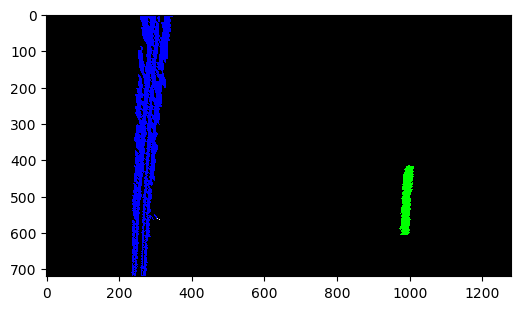

In [188]:
img_color = cv2.cvtColor(img,cv2.COLOR_GRAY2BGR)*255
img_color[[idx[0] for idx in left_points],[idx[1] for idx in left_points]] = [0,0,255]
img_color[[idx[0] for idx in right_points],[idx[1] for idx in right_points]] = [0,255,0]
plt.imshow(img_color)

## Read video frame

In [174]:
videoCapture = cv2.VideoCapture('project_video.mp4')
frames = []
i = 0
while True:
    success,frame = videoCapture.read()
    if success:
        cv2.imwrite("test_images/frame1/%d.png" %i,frame)
        frames.append(frame)
        i += 1
    else:
        break